In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows', 100)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import missingno as msno
import seaborn as sns
from datetime import date,datetime
import os
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
sns.set_palette(colours)
%matplotlib inline
#plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Model selection and evaluation tools
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer
from sklearn.metrics import roc_auc_score, roc_curve, matthews_corrcoef, recall_score
from sklearn.metrics import precision_score, average_precision_score, f1_score, log_loss
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from catboost import CatBoostClassifier, Pool, cv
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, RUSBoostClassifier, EasyEnsembleClassifier

# Data processing
from sklearn.utils import resample

In [5]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from catboost import CatBoostClassifier, Pool, cv

In [6]:
import sys
sys.path.insert(0, './')
from ds_toolbox import plot_coefficients, plot_roc_curve, plot_roc_curves, plot_confusion_matrix, plot_histograms
from ds_toolbox import plot_conditional_distributions, classifier_metric_report, classifiers_metric_report
from ds_toolbox import plot_roc_curves_with_classifiers
from ds_toolbox import create_balanced_dataset, plot_feature_importance, plot_confusion_matrix
from ds_toolbox import plot_confusion_matrix_with_labels, plot_recall_curve,classifier_detailed_report

In [7]:
# checking the current directory
os.getcwd()

'/Users/yg/Google Drive/Insight/data_challenges/TempusLab'

# TOC:

1. Data Wrangling
2. EDA
3. Visual Inspection of Features
4. Model Selection
5. Handling The Imbalanced Classification
    * OverSampling
    * Overfitting Detector
    * UnderSampling
6. Grid Search
7. StratifiedKFold And Grid Search
8. Feature Selection
9. Analysis of the 10 top features
10. Modelisation using top features

########################################################################################

# Data Wrangling <a name="Wrangle"></a>
## Read In The Data <a name="Read"></a>

In [8]:
df = pd.read_csv('DScasestudy_1.txt','\t')
print('Number of rows:',len(df))
df.head()

Number of rows: 530


,response,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,...,V16513,V16514,V16515,V16516,V16517,V16518,V16519,V16520,V16521,V16522,V16523,V16524,V16525,V16526,V16527,V16528,V16529,V16530,V16531,V16532,V16533,V16534,V16535,V16536,V16537,V16538,V16539,V16540,V16541,V16542,V16543,V16544,V16545,V16546,V16547,V16548,V16549,V16550,V16551,V16552,V16553,V16554,V16555,V16556,V16557,V16558,V16559,V16560,V16561,V16562
0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
#df.dtypes

In [10]:
df.describe()

,response,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,...,V16513,V16514,V16515,V16516,V16517,V16518,V16519,V16520,V16521,V16522,V16523,V16524,V16525,V16526,V16527,V16528,V16529,V16530,V16531,V16532,V16533,V16534,V16535,V16536,V16537,V16538,V16539,V16540,V16541,V16542,V16543,V16544,V16545,V16546,V16547,V16548,V16549,V16550,V16551,V16552,V16553,V16554,V16555,V16556,V16557,V16558,V16559,V16560,V16561,V16562
count,530.000000,530.000000,530.000000,530.000000,530.0,530.000000,530.0,530.000000,530.000000,530.0,530.0,530.000000,530.0,530.000000,530.0,530.0,530.0,530.000000,530.000000,530.0,530.000000,530.0,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.0,530.0,530.000000,530.000000,530.000000,530.000000,530.000000,530.0,530.0,530.000000,530.000000,530.000000,530.000000,...,530.000000,530.000000,530.0,530.0,530.000000,530.000000,530.000000,530.000000,530.000000,530.0,530.000000,530.0,530.0,530.000000,530.000000,530.0,530.0,530.0,530.0,530.000000,530.0,530.000000,530.000000,530.0,530.0,530.0,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.000000,530.0,530.0,530.000000,530.000000,530.000000,530.0,530.000000,530.0,530.000000
mean,0.232075,0.009434,0.009434,0.001887,0.0,0.020755,1.0,0.001887,0.030189,0.0,0.0,0.009434,0.0,0.130189,0.0,0.0,0.0,0.416981,0.001887,0.0,0.079245,0.0,0.016981,0.994340,0.022642,0.088679,0.013208,0.079245,0.060377,0.001887,0.184906,0.003774,0.001887,0.990566,0.611321,0.005660,0.001887,0.0,0.0,0.024528,0.128302,0.075472,0.107547,0.001887,0.0,1.0,0.049057,0.015094,0.022642,0.033962,...,0.005660,0.016981,0.0,0.0,0.022642,0.003774,0.007547,0.005660,0.011321,0.0,0.011321,0.0,0.0,0.005660,0.001887,0.0,0.0,0.0,0.0,0.064151,0.0,0.003774,0.058491,0.0,0.0,0.0,0.005660,0.058491,0.039623,0.196226,0.560377,0.001887,0.324528,0.005660,0.300000,0.033962,0.666038,0.013208,0.003774,0.022642,0.158491,0.0,0.0,0.001887,0.020755,0.013208,0.0,0.003774,0.0,0.447170
std,0.422556,0.096761,0.096761,0.043437,0.0,0.142697,0.0,0.043437,0.171268,0.0,0.0,0.096761,0.0,0.336829,0.0,0.0,0.0,0.493526,0.043437,0.0,0.270376,0.0,0.129323,0.075093,0.148898,0.284549,0.114270,0.270376,0.238410,0.043437,0.388588,0.061371,0.043437,0.096761,0.487911,0.075093,0.043437,0.0,0.0,0.154829,0.334742,0.264400,0.310100,0.043437,0.0,0.0,0.216190,0.122043,0.148898,0.181303,...,0.075093,0.129323,0.0,0.0,0.148898,0.061371,0.086628,0.075093,0.105895,0.0,0.105895,0.0,0.0,0.075093,0.043437,0.0,0.0,0.0,0.0,0.245253,0.0,0.061371,0.234890,0.0,0.0,0.0,0.075093,0.234890,0.195255,0.397517,0.496810,0.043437,0.468641,0.075093,0.458691,0.181303,0.472072,0.114270,0.061371,0.148898,0.365545,0.0,0.0,0.043437,0.142697,0.114270,0.0,0.061371,0.0,0.497671
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [11]:
df['response'].value_counts()

0    407
1    123
Name: response, dtype: int64

In [12]:
print("Percent of missing data per column:")
100*df.isna().sum()/len(df)

Percent of missing data per column:


response    0.0
V1          0.0
V2          0.0
V3          0.0
V4          0.0
V5          0.0
V6          0.0
V7          0.0
V8          0.0
V9          0.0
V10         0.0
V11         0.0
V12         0.0
V13         0.0
V14         0.0
V15         0.0
V16         0.0
V17         0.0
V18         0.0
V19         0.0
V20         0.0
V21         0.0
V22         0.0
V23         0.0
V24         0.0
V25         0.0
V26         0.0
V27         0.0
V28         0.0
V29         0.0
V30         0.0
V31         0.0
V32         0.0
V33         0.0
V34         0.0
V35         0.0
V36         0.0
V37         0.0
V38         0.0
V39         0.0
V40         0.0
V41         0.0
V42         0.0
V43         0.0
V44         0.0
V45         0.0
V46         0.0
V47         0.0
V48         0.0
V49         0.0
           ... 
V16513      0.0
V16514      0.0
V16515      0.0
V16516      0.0
V16517      0.0
V16518      0.0
V16519      0.0
V16520      0.0
V16521      0.0
V16522      0.0
V16523      0.0
V16524  

In [13]:
#msno.bar(df, color="blue", figsize=(30,18));

# EDA <a name="EDA"></a>

## Class Imbalance <a name="ClassImbalance"></a>

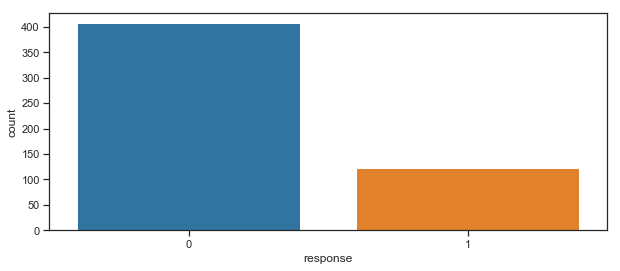

In [14]:
plt.figure(figsize=(10,4))
#plt.figure(figsize=(15,4))
sns.countplot(df['response']);
#plt.savefig('./figures/imbalanced_data.pdf')

## Visual Inspection Of Features <a name="VizFeatures"></a>

### Principal Component Analysis <a name="PCA"></a>

In [15]:
input_df = df[df.columns[1:]]
input_df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       ...
       'V16553', 'V16554', 'V16555', 'V16556', 'V16557', 'V16558', 'V16559',
       'V16560', 'V16561', 'V16562'],
      dtype='object', length=16562)

In [16]:
data = input_df.values

In [17]:
n_components = 400

pca = PCA(n_components=n_components)

principal_components = pca.fit_transform(data)

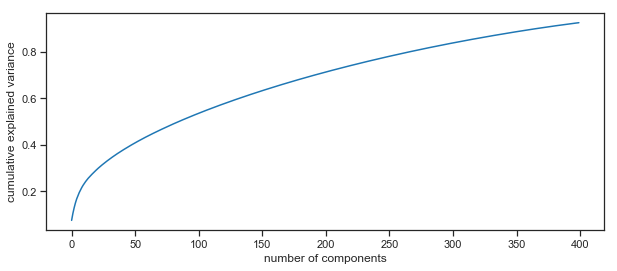

In [18]:
plt.figure(figsize=(10,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
#plt.savefig(r'./figures/pca_components.pdf', bbox_inches='tight', transparent=True);

In [19]:
principal_dataframe = pd.DataFrame(data=principal_components[:,0:2],
                                  columns=['component 1', 'component 2'])

principal_dataframe_labeled = pd.concat([principal_dataframe,
                                         df[['response']]],
                                         axis=1)

In [20]:
principal_dataframe_labeled.head()

,component 1,component 2,response
0,-2.148421,4.957650,1
1,2.165692,-0.949024,1
2,-4.991627,-2.884589,1
3,8.241123,1.284378,1
4,2.149416,0.664141,1


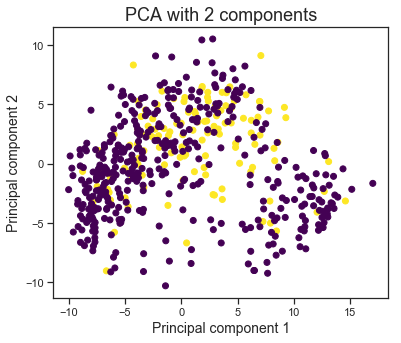

In [21]:
plt.figure(figsize=(6,5))

plt.scatter(principal_dataframe_labeled['component 1'],
           principal_dataframe_labeled['component 2'],
           c = principal_dataframe_labeled['response'],
           cmap = 'viridis')

plt.xlabel('Principal component 1', fontsize=14)
plt.ylabel('Principal component 2', fontsize=14)

plt.title('PCA with 2 components', fontsize=18);
#plt.savefig(r'./figures/pca_two_components.pdf', bbox_inches='tight', transparent=True);

# Model Selection

In [22]:
# Split into training and test sets
X = df.drop(columns = ['response'])
y = df['response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [23]:
print('#X={}, #y={}'.format(X.shape,y.shape))
print('#X_train={}, #y_train={}'.format(X_train.shape, y_train.shape))
print('#X_test={}, #y_test={}'.format(X_test.shape,y_test.shape))

#X=(530, 16562), #y=(530,)
#X_train=(424, 16562), #y_train=(424,)
#X_test=(106, 16562), #y_test=(106,)


In [24]:
df['response'].value_counts()

0    407
1    123
Name: response, dtype: int64

In [25]:
feature_names = list(X.columns.values)
categorical_features_indices = np.where(X.dtypes != np.float)[0]
categorical_features_indices

array([    0,     1,     2, ..., 16559, 16560, 16561])

In [26]:
classifiers = [
    CatBoostClassifier(logging_level='Silent'),
    RidgeClassifier(),
    LogisticRegression(),
    ExtraTreesClassifier(),
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025,gamma = 'scale',probability=True),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]
classifier_labels = []

In [27]:
probabilities = np.zeros((len(y_test), len(classifiers)))
for i, clf in enumerate(classifiers):
    name = clf.__class__.__name__
    print("="*30)
    print('Training:{}'.format(name))
    classifier_labels.append(name)
    if name == 'CatBoostClassifier':
        clf.fit(X_train,y_train, cat_features=categorical_features_indices)
    else:
        clf.fit(X_train, y_train)
    if name == 'RidgeClassifier':
        d = clf.decision_function(X_test)
        probs = np.exp(d) / np.sum(np.exp(d))
        probabilities[:,i] = probs
    else:
        probabilities[:,i] = np.array(clf.predict_proba(X_test)[:,1])

Training:CatBoostClassifier
Training:RidgeClassifier
Training:LogisticRegression
Training:ExtraTreesClassifier
Training:KNeighborsClassifier
Training:SVC
Training:RandomForestClassifier
Training:AdaBoostClassifier
Training:GradientBoostingClassifier
Training:GaussianNB
Training:LinearDiscriminantAnalysis
Training:QuadraticDiscriminantAnalysis


In [28]:
metrics = classifiers_metric_report(classifiers, classifier_labels, X_test, y_test)
metrics.round(3)

,Precision,Recall,F1-Score,Specificity,LogLoss
CatBoostClassifier,0.923,0.915,0.908,0.988,2.933
RidgeClassifier,0.882,0.934,0.932,0.977,2.281
LogisticRegression,0.882,0.934,0.932,0.977,2.281
ExtraTreesClassifier,0.917,0.906,0.896,0.988,3.258
KNeighborsClassifier,0.500,0.811,0.768,0.965,6.517
SVC,0.000,0.811,0.727,1.000,6.517
RandomForestClassifier,0.800,0.840,0.798,0.988,5.539
AdaBoostClassifier,0.500,0.811,0.815,0.872,6.517
GradientBoostingClassifier,0.923,0.915,0.908,0.988,2.933
GaussianNB,0.250,0.792,0.732,0.965,7.168


In [29]:
for c in list(metrics.columns):
    metrics[c] = metrics[c].apply(lambda x: x * 100.0)

metric_values = list(metrics.index.values)

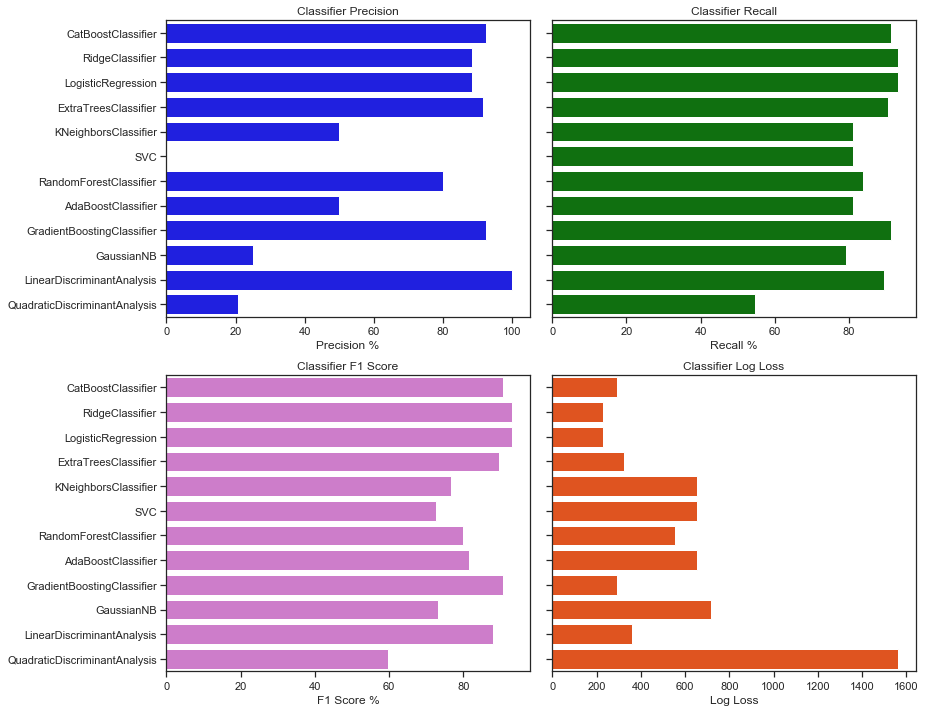

In [30]:
fig, ax = plt.subplots(2,2,figsize = (13,10), sharey = True)
sns.barplot(x='Precision', y=metric_values, data=metrics, color="b",ax = ax[0,0])
ax[0,0].set_xlabel('Precision %')
ax[0,0].set_title('Classifier Precision')
sns.barplot(x='Recall', y=metric_values, data=metrics, color="g", ax = ax[0,1])
ax[0,1].set_xlabel('Recall %')
ax[0,1].set_ylabel('')
ax[0,1].set_title('Classifier Recall')
sns.barplot(x='F1-Score', y=metric_values, data=metrics, color="orchid", ax = ax[1,0])
ax[1,0].set_xlabel('F1 Score %')
ax[1,0].set_title('Classifier F1 Score')
sns.barplot(x='LogLoss', y=metric_values, data=metrics, color="orangered", ax = ax[1,1])
ax[1,1].set_xlabel('Log Loss')
ax[1,1].set_ylabel('')
ax[1,1].set_title('Classifier Log Loss')
plt.subplots_adjust(wspace = 0)
plt.tight_layout()
#plt.savefig('./figures/classifier_comparison.pdf')
plt.show()

Overall CatBoost and GradientBoosting classifiers have better performances on average than the other classifiers.
Lets zoom into the metrics per class ('0' or '1') for the response variable for each classifier.

In [31]:
detailed_metrics = classifier_detailed_report(classifiers, classifier_labels, X_test, y_test)
detailed_metrics.round(3)

,0_F1Score,0_Precision,0_Recall,0_Support,1_F1Score,1_Precision,1_Recall,1_Support
CatBoostClassifier,0.950,0.914,0.988,86.0,0.727,0.923,0.60,20.0
RidgeClassifier,0.960,0.944,0.977,86.0,0.811,0.882,0.75,20.0
LogisticRegression,0.960,0.944,0.977,86.0,0.811,0.882,0.75,20.0
ExtraTreesClassifier,0.944,0.904,0.988,86.0,0.687,0.917,0.55,20.0
KNeighborsClassifier,0.892,0.830,0.965,86.0,0.231,0.500,0.15,20.0
SVC,0.896,0.811,1.000,86.0,0.000,0.000,0.00,20.0
RandomForestClassifier,0.909,0.842,0.988,86.0,0.320,0.800,0.20,20.0
AdaBoostClassifier,0.882,0.893,0.872,86.0,0.524,0.500,0.55,20.0
GradientBoostingClassifier,0.950,0.914,0.988,86.0,0.727,0.923,0.60,20.0
GaussianNB,0.883,0.814,0.965,86.0,0.083,0.250,0.05,20.0


In [32]:
detailed_metrics = detailed_metrics[['0_F1Score','0_Precision','0_Recall','1_F1Score','1_Precision','1_Recall']]
for c in list(detailed_metrics.columns):
    detailed_metrics[c] = detailed_metrics[c].apply(lambda x: x * 100.0)
detailed_metrics_data = list(detailed_metrics.index.values)    

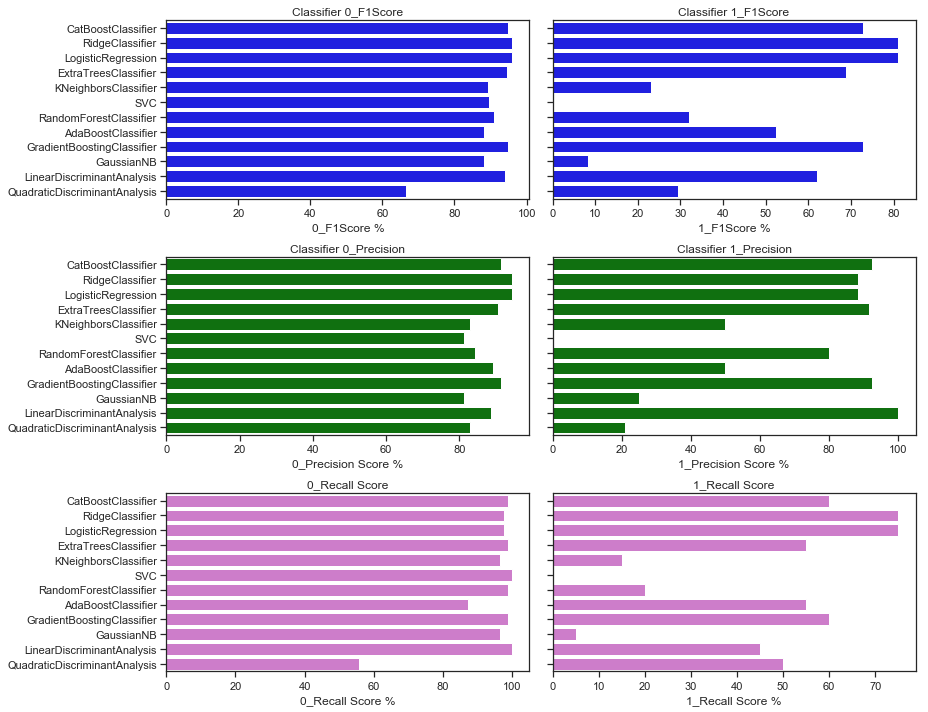

In [33]:
fig, ax = plt.subplots(3,2,figsize = (13,10), sharey = True)

sns.barplot(x='0_F1Score', y=detailed_metrics_data, data=detailed_metrics, color="b",ax = ax[0,0])
ax[0,0].set_xlabel('0_F1Score %')
ax[0,0].set_ylabel('')
ax[0,0].set_title('Classifier 0_F1Score')
sns.barplot(x='1_F1Score', y=detailed_metrics_data, data=detailed_metrics, color="b",ax = ax[0,1])
ax[0,1].set_xlabel('1_F1Score %')
ax[0,1].set_ylabel('')
ax[0,1].set_title('Classifier 1_F1Score')

sns.barplot(x='0_Precision', y=detailed_metrics_data, data=detailed_metrics, color="g", ax = ax[1,0])
ax[1,0].set_xlabel('0_Precision Score %')
ax[1,0].set_ylabel('')
ax[1,0].set_title('Classifier 0_Precision')
sns.barplot(x='1_Precision', y=detailed_metrics_data, data=detailed_metrics, color="g", ax = ax[1,1])
ax[1,1].set_xlabel('1_Precision Score %')
ax[1,1].set_ylabel('')
ax[1,1].set_title('Classifier 1_Precision')

sns.barplot(x='0_Recall', y=detailed_metrics_data, data=detailed_metrics, color="orchid", ax = ax[2,0])
ax[2,0].set_xlabel('0_Recall Score %')
ax[2,0].set_title('0_Recall Score')
ax[2,0].set_ylabel('')
sns.barplot(x='1_Recall', y=detailed_metrics_data, data=detailed_metrics, color="orchid", ax = ax[2,1])
ax[2,1].set_xlabel('1_Recall Score %')
ax[2,1].set_title('1_Recall Score')
ax[2,1].set_ylabel('')


plt.subplots_adjust(wspace = 0)
plt.tight_layout()
#plt.savefig('./figures/detailed_classifier_comparison.pdf')
plt.show()

Depending on the problems, the graphs above can lead you to favor one classifier over the other ones.
For example, if you want to predict a positive response, let's assume "1" over the negative "0",
and you want to reach the highest specificity or recall for the positive class, then you may want to choose 
the ridge or logistic classifier. Since we don't have enough details for the problem at hand, we will select the CatBoost classifier which has overall good performances. 
In addition CatBoost support categorical variables and the values of these features are all 0 or 1.

<Figure size 432x360 with 0 Axes>

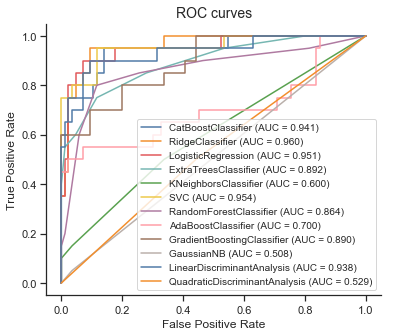

In [34]:
plt.figure(figsize=(6,5))
plot_roc_curves_with_classifiers(probabilities, y_test, classifier_labels);
plt.show()
#plt.savefig('./figures/roc_curves_comparison_2.pdf');

The AUC for the CatBoost classifier is one of the largest, which is for a balanced dataset, is what we are looking since a skilful model will assign a higher probability to a randomly chosen real positive occurrence than a negative occurrence on average. And a pure random selection will be  the represented by the diagonal line cutting the plane in half. However the data set is imbalanced so we will look also into the precision-recall curve.

In [35]:
cb  = classifiers[0]
print(cb.__class__.__name__)

CatBoostClassifier


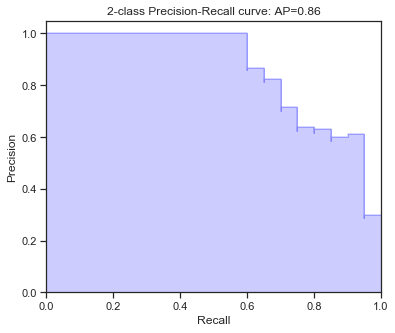

In [36]:
probs = np.array(cb.predict_proba(X_test)[:,1])
plot_recall_curve(y_test,probs);
#plt.savefig('./figures/catboost_precision_recall_curve.pdf')

The curve is the sign of a good classifier but again without more details, I am assumingCatBoost classifier
is the right model to investigate.

Confusion matrix, without normalization


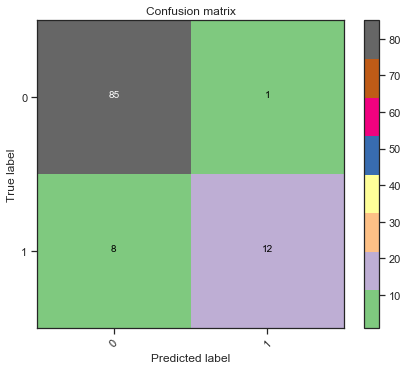

In [37]:
plt = plot_confusion_matrix_with_labels(X_test, y_test, cb, cb.classes_)
plt.show()
#plt.savefig('./figures/catboost_confusion_matrix_1.pdf')

40% of False negatives.

<Figure size 432x360 with 0 Axes>

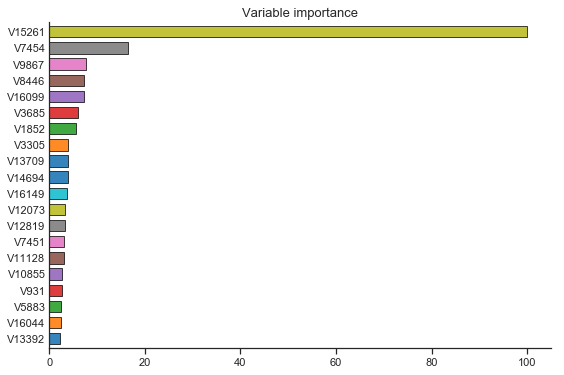

In [38]:
plt.figure(figsize=(6,5))
plot_feature_importance(cb, feature_names);
#plt.savefig('./figures/catboost_features_ranking_1.pdf')

The feature importance ranking given by the CatBoost classifier shows a primarily overweighted variable: V15261.

# Handling The Imbalanced Classification

# OverSampling

In [39]:
X_sampled, y_sampled = create_balanced_dataset('SMOTE', X_train, y_train)

X=(424, 16562), y=[(0, 321), (1, 103)]
X_sampled=(642, 16562), y_sampled=[(0, 321), (1, 321)]


In [40]:
X_sampled.shape

(642, 16562)

In [41]:
X_train, X_validation, y_train, y_validation = train_test_split(X_sampled, y_sampled, train_size=0.8, random_state=1234)

In [42]:
print('#X={}, #y={}'.format(X.shape,y.shape))
print('#X_train={}, #y_train={}, #X_validation={}, #y_validation={}'.format(X_train.shape, y_train.shape, X_validation.shape, y_validation.shape))
print('#X_test={}, #y_test={}'.format(X_test.shape,y_test.shape))

#X=(530, 16562), #y=(530,)
#X_train=(513, 16562), #y_train=(513,), #X_validation=(129, 16562), #y_validation=(129,)
#X_test=(106, 16562), #y_test=(106,)


In [43]:
initial_cb = CatBoostClassifier(
    iterations=50,
    random_seed=63,
    learning_rate=0.5,
    custom_loss=['Accuracy','Precision', 'Recall'],
    logging_level='Silent'
)
initial_cb.fit(
    X_train, y_train,
    #cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

If we observe the learning curves, we can see that the training and test loglosses decrease nicely up to until 15 then the test error, past the critical number of iterations (15), starts increasing again.
Accuracy and recall do not improve past 15 iteration. And precision, in fact, decreases, to stabilize to a value lower to the one reached around 15 iterations.
All these results suggest an overfitting.

In [44]:
report = classifiers_metric_report([initial_cb], ['CatBoost Classifier'], X_test, y_test)
report.round(3)

,Precision,Recall,F1-Score,Specificity,LogLoss
CatBoost Classifier,0.458,0.792,0.799,0.849,7.169


Confusion matrix, without normalization


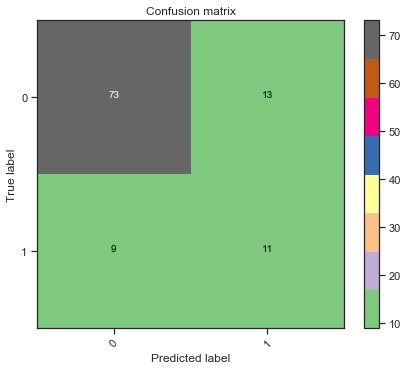

In [45]:
plot_confusion_matrix_with_labels(X_test, y_test, initial_cb, initial_cb.classes_);

The CatBoost classifier performances are degraded due to overfitting.

# Overfitting Detector

CatBoost provides an overfitting detector set with the parameter od_type.
I used the 'Iter' method:  before building each new tree, CatBoost checks 
the number of iterations since the iteration with the optimal loss function value.
The model is considered overfitted if the number of iterations exceeds 
the value specified in the training parameters. 

In [46]:
model_with_early_stop = CatBoostClassifier(
    od_type = 'Iter',
    use_best_model=True,
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
     custom_loss=['Accuracy','Precision', 'Recall'],
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    #cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [47]:
print(model_with_early_stop.tree_count_)

12


12 trees is the optimal number of trees.

In [48]:
tuned_cb = CatBoostClassifier(
    iterations=12,
    random_seed=63,
    learning_rate=0.5,
#     l2_leaf_reg = 9,
#     depth = 4,
    custom_loss=['Accuracy','Precision', 'Recall'],
    logging_level='Silent'
)
tuned_cb.fit(
    X_train, y_train,
    #cat_features=categorical_features_indices,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [49]:
report = classifiers_metric_report([tuned_cb], ['CatBoost Classifier'], X_test, y_test)
report.round(3)

,Precision,Recall,F1-Score,Specificity,LogLoss
CatBoost Classifier,0.458,0.792,0.799,0.849,7.169


Confusion matrix, without normalization


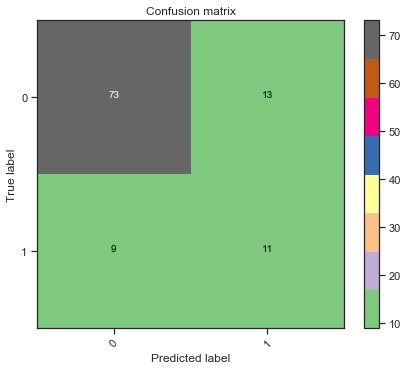

In [50]:
plot_confusion_matrix_with_labels(X_test, y_test, tuned_cb, tuned_cb.classes_);

No changes in the metrics.

# UnderSampling

In [51]:
# Separate majority and minority classes

df_majority = df[df['response']==0]
df_minority = df[df['response']==1]    

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=123,    # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled['response'].value_counts()

1    123
0    123
Name: response, dtype: int64

In [52]:
X_sampled = df_downsampled[df_downsampled.columns[:-1]]
y_sampled = df_downsampled['response']


# Create classifier
clf_down = LogisticRegression()
#clf_down = LogisticRegression(penalty='l2', class_weight=None, C=0.001)

# Train model
clf_down.fit(X_sampled, y_sampled)

# Get predicted probabilities
y_score = clf_down.predict_proba(X_test)[:,1]

In [53]:
report = classifiers_metric_report([clf_down], ['DownSampled  LogisticRegression Classifier'], X_test, y_test)
report.round(3)

,Precision,Recall,F1-Score,Specificity,LogLoss
DownSampled LogisticRegression Classifier,0.155,0.434,0.492,0.43,19.551


Confusion matrix, without normalization


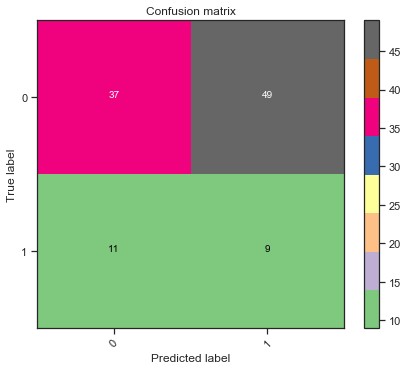

In [54]:
plot_confusion_matrix_with_labels(X_test, y_test, clf_down, clf_down.classes_);

Perfomances are worst than using upsampling.

# Grid Search

In [55]:
%%time
model = CatBoostClassifier(logging_level='Silent')
tuning_parameters = {'depth': [4, 7, 10],
             'learning_rate' : [0.5],
             'l2_leaf_reg': [1,4,9],
             'iterations': [12]}

cb_search = GridSearchCV(model, tuning_parameters, cv = 3, return_train_score=False)
cb_search.fit(X, y)
print('Best parameters:', cb_search.best_params_)
grid_cb = cb_search.best_estimator_

Best parameters: {'depth': 4, 'iterations': 12, 'l2_leaf_reg': 9, 'learning_rate': 0.5}
CPU times: user 6min 41s, sys: 1min 3s, total: 7min 45s
Wall time: 1min 38s


The tuned hyperparameters are:
    * depth: 4
    * trees or iterations: 12
    * l2_leaf_reg: 9
    * learning_rate: 0.5

In [56]:
y_pred = grid_cb.predict(X_test)

In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        86
           1       1.00      0.70      0.82        20

   micro avg       0.94      0.94      0.94       106
   macro avg       0.97      0.85      0.89       106
weighted avg       0.95      0.94      0.94       106



In [58]:
report = classifiers_metric_report([grid_cb], ['GridSearch CatBoost Classifier'], X_test, y_test)
report.round(3)

,Precision,Recall,F1-Score,Specificity,LogLoss
GridSearch CatBoost Classifier,1.0,0.943,0.939,1.0,1.955


In [59]:
mat_score = matthews_corrcoef(y_test, y_pred)
print('Matthew Coefficient={}'.format(mat_score))

Matthew Coefficient=0.8089176880789273


Matthew Coefficient is a measure of the quality of a binary (two-class) classification.
A coefficient of +1 represents a perfect prediction, so this classifier has good prediction power.

Confusion matrix, without normalization


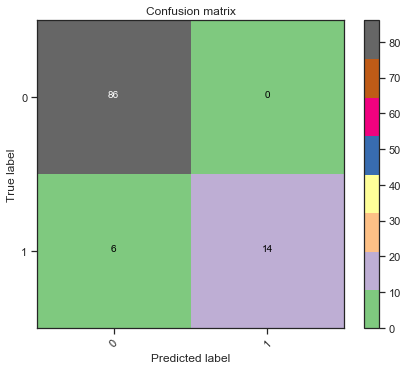

In [60]:
plot_confusion_matrix_with_labels(X_test, y_test, grid_cb, grid_cb.classes_);

Performances have improved, we have now 30% of false negatives and zero false positives.

# StratifiedKFold and Grid Search

In [61]:
pipe = Pipeline([
    ('clf', CatBoostClassifier(logging_level='Silent'))
    ])

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

refit_score='recall_score'

tuning_parameters = {'clf__depth': [4,7,10],
             'clf__learning_rate' : [0.5],
             'clf__l2_leaf_reg': [1,4,9],
             'clf__iterations': [12]}



skf = StratifiedKFold(n_splits=10)
stratified_cb_search = GridSearchCV(pipe, tuning_parameters, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True)
stratified_cb_search.fit(X, y)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('clf', <catboost.core.CatBoostClassifier object at 0x1a1de1d898>)]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'clf__depth': [4, 7, 10], 'clf__learning_rate': [0.5], 'clf__l2_leaf_reg': [1, 4, 9], 'clf__iterations': [12]},
       pre_dispatch='2*n_jobs', refit='recall_score',
       return_train_score=True,
       scoring={'precision_score': make_scorer(precision_score), 'recall_score': make_scorer(recall_score), 'accuracy_score': make_scorer(accuracy_score)},
       verbose=0)

In [62]:
print('Best parameters:', stratified_cb_search.best_params_)

Best parameters: {'clf__depth': 10, 'clf__iterations': 12, 'clf__l2_leaf_reg': 9, 'clf__learning_rate': 0.5}


In [63]:
stratified_cb = stratified_cb_search.best_estimator_

Confusion matrix, without normalization


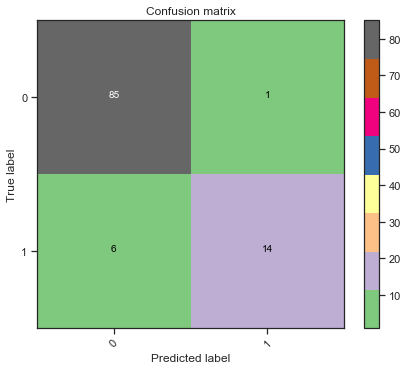

In [64]:
plot_confusion_matrix_with_labels(X_test, y_test, stratified_cb, stratified_cb.classes_);

# Feature Selection

In [65]:
feature_importance = grid_cb.feature_importances_ * 100
feature_importance = 100 * (feature_importance / np.max(feature_importance))
table = pd.Series(feature_importance, index=feature_names).sort_values(ascending=False, inplace=False)

In [66]:
table.head()

V7454     100.000000
V15261     52.772046
V9867      16.099039
V6583      14.916196
V11178     12.202451
dtype: float64

In [78]:
top_features = list(table.index.values)[:10]
top_features

['V7454',
 'V15261',
 'V9867',
 'V6583',
 'V11178',
 'V1931',
 'V3685',
 'V2670',
 'V12949',
 'V1852']

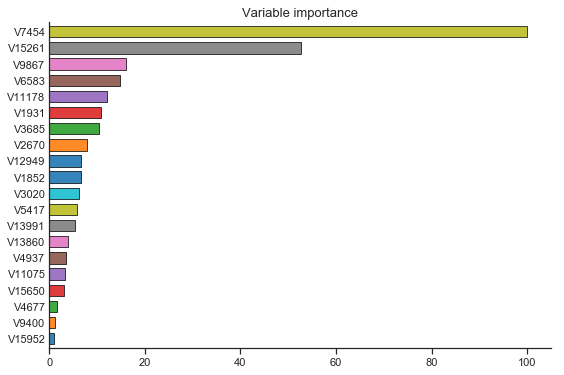

In [79]:
plot_feature_importance(grid_cb, feature_names);

# Analysis of 10 top features

There are too many features to plot them all. But later by selecting a performing model, we have 
an estimation of the 10 most important features. And we will plot them.

In [81]:
top_features.append('response')
top_features

['V7454',
 'V15261',
 'V9867',
 'V6583',
 'V11178',
 'V1931',
 'V3685',
 'V2670',
 'V12949',
 'V1852',
 'response']

In [82]:
top_features_df = df[top_features]
top_features_df.head()

,V7454,V15261,V9867,V6583,V11178,V1931,V3685,V2670,V12949,V1852,response
0,0,0,0,1,0,1,0,1,0,0,1
1,1,1,0,1,0,0,0,0,0,0,1
2,0,0,0,1,0,0,1,0,1,0,1
3,1,1,1,0,1,1,1,0,1,0,1
4,1,1,1,1,1,1,1,0,0,0,1


In [89]:
mcc_scores = []
for col in top_features[:-1]:
    mcc_score = matthews_corrcoef(top_features_df['response'], top_features_df[col])
    mcc_scores.append((col, mcc_score))
   

In [96]:
mcc_scores.sort(key=lambda x: x[1], reverse=True)
for (f,score) in mcc_scores:
     print('(response, {}) Matthews correlation coefficient={}'.format(f, score))

(response, V15261) Matthews correlation coefficient=0.6554164042835914
(response, V7454) Matthews correlation coefficient=0.5881890171432996
(response, V9867) Matthews correlation coefficient=0.5170027699204074
(response, V3685) Matthews correlation coefficient=0.31131222256677316
(response, V1931) Matthews correlation coefficient=0.2525669343467885
(response, V2670) Matthews correlation coefficient=0.24682495751910052
(response, V12949) Matthews correlation coefficient=0.24148084193126995
(response, V6583) Matthews correlation coefficient=0.11135140983504965
(response, V11178) Matthews correlation coefficient=0.056842523597486795
(response, V1852) Matthews correlation coefficient=0.01811187407776393


I see some correlation between the top three features and the response variable.

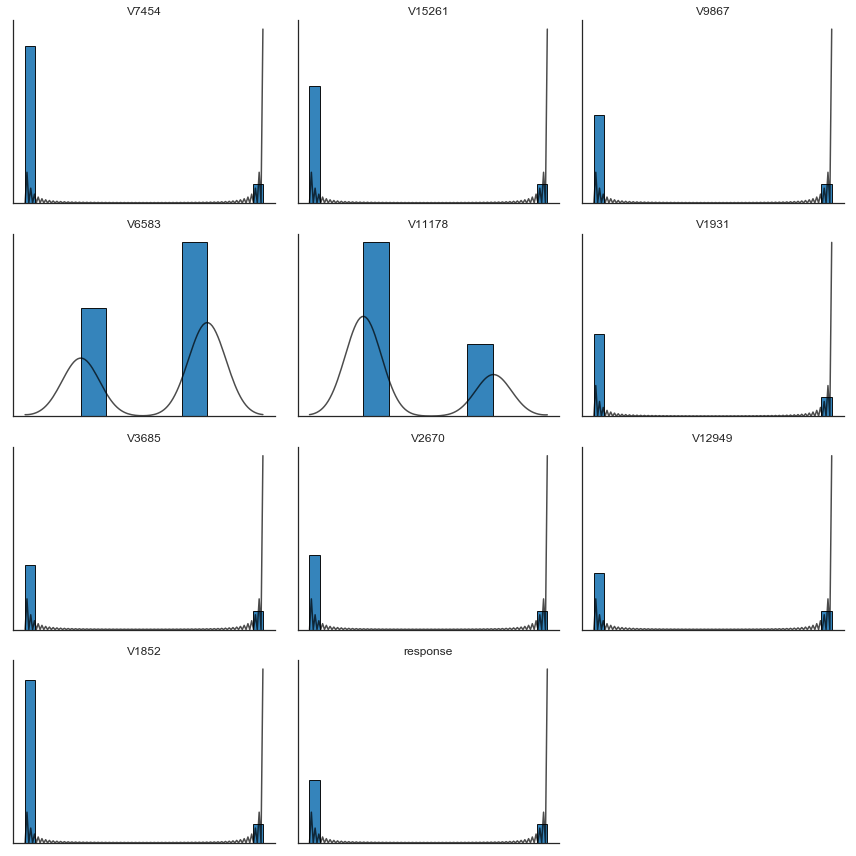

In [97]:
plot_histograms(top_features_df);

# Modelisation using top features

In [98]:
small_df = df[top_features]
small_df.head()

,V7454,V15261,V9867,V6583,V11178,V1931,V3685,V2670,V12949,V1852,response
0,0,0,0,1,0,1,0,1,0,0,1
1,1,1,0,1,0,0,0,0,0,0,1
2,0,0,0,1,0,0,1,0,1,0,1
3,1,1,1,0,1,1,1,0,1,0,1
4,1,1,1,1,1,1,1,0,0,0,1


In [99]:
small_X = small_df.drop(columns = ['response'])
small_y = small_df['response']
small_X_train, small_X_test, small_y_train, small_y_test = train_test_split(small_X, small_y, test_size=0.2, random_state=1)

In [100]:
small_X_train, small_X_validation, small_y_train, small_y_validation = train_test_split(small_X_train, small_y_train, train_size=0.8, random_state=1234)

In [103]:
grid_cb.fit(
    small_X_train, small_y_train,
    eval_set=(small_X_validation, small_y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Confusion matrix, without normalization


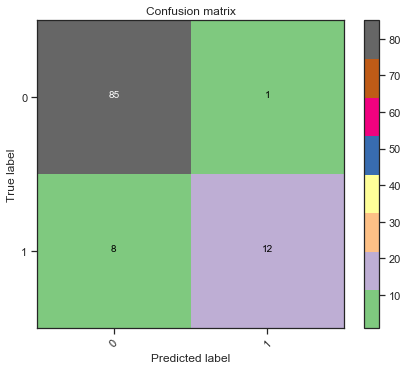

In [105]:
plot_confusion_matrix_with_labels(small_X_test, small_y_test, grid_cb, grid_cb.classes_);

No better performances, I drop this idea.